In [1]:
train_model = False

## Pre-Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install atlas_mpl_style
!pip install uproot3

In [4]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/content/drive/MyDrive/EPE/ML4Pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

/usr/local/lib/python3.7/dist-packages/atlas_mpl_style/__init__.py:164: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  "No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False"


In [5]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu
import uproot3 as ur

/usr/local/lib/python3.7/dist-packages/atlas_mpl_style/__init__.py:164: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  "No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False"
/usr/local/lib/python3.7/dist-packages/atlas_mpl_style/__init__.py:164: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  "No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False"


In [6]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [7]:
import tensorflow as tf
import tensorflow_probability as tfp

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [8]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu


def _q16(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 16)

def _q84(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 84)

def responsePlot(x, y, figfile='', statistic='median',
                 xlabel='True Energy [GeV]', ylabel='Predicted Energy / True Energy',
                 xlim=(0.3,1000), ylim=(0,3), baseline=True,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    xbin = [10**exp for exp in np.arange(-1.0, 3.1, 0.1)]
    ybin = np.arange(0., 3.1, 0.1)
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    
    responseMed = stats.binned_statistic(x, y, bins=xbin, statistic=statistic).statistic
    responseQ16 = stats.binned_statistic(x, y, bins=xbin, statistic=_q16).statistic
    responseQ84 = stats.binned_statistic(x, y, bins=xbin, statistic=_q84).statistic

    responseQ16 = responseMed - responseQ16
    responseQ84 = responseQ84 - responseMed

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1)
    plt.errorbar(xcenter, responseMed, yerr=[responseQ16,responseQ84], color='red')
    if baseline:
        plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black')
    plt.xscale('log')
    plt.ylim(ylim)
    plt.xlim(xlim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)
    # ampl.set_zlabel('Clusters')
    cb = plt.colorbar()
    cb.ax.set_ylabel('Clusters')
    # plt.legend()

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, responseMed


def _iqr(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return q84 - q16


def resolutionPlot(x, y, figfile='', statistic='iqr',
                   xlabel='True Energy [GeV]', ylabel='Response IQR',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqr).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(0.3, 1000)
    plt.ylim(0,2)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution


In [9]:
# import pi+

inputpath = '/content/drive/Shareddrives/UWEPEML/ML4Pion/v7/'
ptypes = ["pi0", "piplus"]
trees = {
    ptype : ur.open(inputpath+ptype+'.root')['ClusterTree']
    for ptype in ptypes
}
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pdata = {
    ptype : itree.pandas.df(branches, flatten=False)
    for ptype, itree in trees.items()
}

print("Number of pi0 events: {}".format(len(pdata['pi0'])))
print("Number of pi+ events: {}".format(len(pdata['piplus'])))

Number of pi0 events: 263891
Number of pi+ events: 435967


In [10]:
#define convenience columns
for ptype in ptypes:
    pdata[ptype]['clusterEoverCalib'] = pdata[ptype].clusterE / pdata[ptype].cluster_ENG_CALIB_TOT
    pdata[ptype]['clusterEoverTruth'] = pdata[ptype].clusterE / pdata[ptype].truthE
    pdata[ptype]['cluster_ENG_ALL'] = pdata[ptype].cluster_ENG_CALIB_TOT + pdata[ptype].cluster_ENG_CALIB_OUT_T + pdata[ptype].cluster_ENG_CALIB_DEAD_TOT

In [11]:
# regression variables: define up here to make it easier for later swapping

for ptype in ptypes:
    pdata[ptype]['logE'] = np.log(pdata[ptype].clusterE)
    pdata[ptype]['logECalib'] = np.log(pdata[ptype].cluster_ENG_CALIB_TOT)
    pdata[ptype]['logECalibAll'] = np.log(pdata[ptype].cluster_ENG_ALL)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler_cal = {}
for ptype in ptypes:
    # create scaler
    scaler_e = StandardScaler()
    scaler_cal[ptype] = StandardScaler()
    scaler_calAll = StandardScaler()
    # fit and transform in one step
    pdata[ptype]['s_logE'] = scaler_e.fit_transform(pdata[ptype]['logE'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalib'] = scaler_cal[ptype].fit_transform(pdata[ptype]['logECalib'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalibAll'] = scaler_calAll.fit_transform(pdata[ptype]['logECalibAll'].to_numpy().reshape(-1,1))


In [13]:
# fun cleaning for EMProb
epsilon = 0.000000000001

for ptype in ptypes:
    pdata[ptype]['cluster_fixEM'] = pdata[ptype].cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

In [14]:
for ptype in ptypes:
    pdata[ptype]['cluster_logEM'] = np.log(pdata[ptype].cluster_fixEM)

    scaler_EM = StandardScaler()
    pdata[ptype]['s_logEM'] = scaler_EM.fit_transform(pdata[ptype].cluster_logEM.to_numpy().reshape(-1,1))

    scaler_eta = StandardScaler()
    pdata[ptype]['s_eta'] = scaler_eta.fit_transform(pdata[ptype].clusterEta.to_numpy().reshape(-1,1))

    pdata[ptype]['logCenter'] = np.log(pdata[ptype].cluster_CENTER_MAG)
    scaler_center = StandardScaler()
    pdata[ptype]['s_logCenter'] = scaler_center.fit_transform(pdata[ptype].logCenter.to_numpy().reshape(-1,1))

    scaler_density = StandardScaler()
    pdata[ptype]['s_Density'] = scaler_density.fit_transform(pdata[ptype].cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [15]:
# define convience sub-frames

for ptype in ptypes:
    pdata[ptype]['Single'] = pdata[ptype].nCluster==1 # define a subset of events with only one cluster
    mu.splitFrameTVT(pdata[ptype], trainfrac = 0.7)   # define a train/test fraction of 70/20% (10% for val at this point)

In [16]:
All_input = {}

for ptype in ptypes:
    EMB1_cells = mu.setupCells(trees[ptype], 'EMB1') # implicitly flatten
    EMB2_cells = mu.setupCells(trees[ptype], 'EMB2')
    EMB3_cells = mu.setupCells(trees[ptype], 'EMB3') # implicitly flatten

    TileBar0_cells = mu.setupCells(trees[ptype], 'TileBar0') # implicitly flatten
    TileBar1_cells = mu.setupCells(trees[ptype], 'TileBar1') # implicitly flatten
    TileBar2_cells = mu.setupCells(trees[ptype], 'TileBar2') # implicitly flatten

    combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
    s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
    All_input[ptype] = np.column_stack((pdata[ptype]['s_logE'],pdata[ptype]['s_eta'],s_All_cells))

# DNN Quantile Prediction

In [17]:
quantiles = [0.16, 0.5, 0.84]

def GAE(y_true, y_pred):
    sgn = -(y_true - y_pred) / K.abs(y_true - y_pred)
    return (0.5-sgn*0.5+sgn*0.84)*K.abs(y_true - y_pred)

def get_GAE(q):
    def GAE_q(y_true, y_pred):
#         if( (y_true - y_pred) == 0 ):
#             return 0.0
        sgn = -(y_true - y_pred) / (K.abs(y_true - y_pred)+K.epsilon())
        return (0.5-sgn*0.5+sgn*q)*K.abs(y_true - y_pred)
    return GAE_q

quantile_loss = [
    get_GAE(q) for q in quantiles
]

In [18]:
regressor_q = []
for q,loss in zip(quantiles,quantile_loss):
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    used_pixels = number_pixels + 2
    regressor_q.append(Sequential([
        Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'),
        Dense(used_pixels, activation='relu'),
        Dense(int(used_pixels/2), activation='relu'),
        Dense(units=1, kernel_initializer='normal', activation='linear'),
    ]))
    
    opt = Adam(lr=1e-4, decay=1e-6)
    regressor_q[-1].compile(optimizer=opt, loss=get_GAE(q), metrics=['mae','mse'])

In [19]:
if train_model:
    # train models
    for q, rq in zip(quantiles,regressor_q):
        callbacks = [tf.keras.callbacks.ModelCheckpoint(modelpath + 'quantile_' + str(q) + '.h5', monitor='loss', verbose=1, save_best_only=True)]
        history = rq.fit(
            All_input['piplus'][pdata['piplus'].train],
            pdata['piplus'][pdata['piplus'].train].s_logECalib.to_numpy(),
            batch_size=200, epochs=50,
            callbacks=callbacks
            )
        # rq.save(modelpath + 'quantile_' + str(q) + '.h5')
else:
    # load models
    for i, (rq, q, loss) in enumerate(zip(regressor_q,quantiles,quantile_loss)):
        regressor_q[i] = load_model(modelpath + 'quantile_' + str(q) + '.h5',
                                    custom_objects={'GAE_q':loss})


In [20]:
for rq, q in zip(regressor_q,quantiles):
    pdata['piplus']['quantile_'+str(q)] = np.exp(
        scaler_cal['piplus'].inverse_transform(rq.predict(All_input['piplus']))
    )
    pdata['piplus']['quantile_'+str(q)+'_EoverCalib'] = pdata['piplus']['quantile_'+str(q)] / pdata['piplus'].cluster_ENG_CALIB_TOT
    
#     pdata['piplus']['quantile_'+str(q)] = np.exp(scaler_cal['piplus'].inverse_transform(
#         rq.predict([pdata['piplus'].s_logE.to_numpy()])
#     ))

#### DNN Quantile Visualization

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

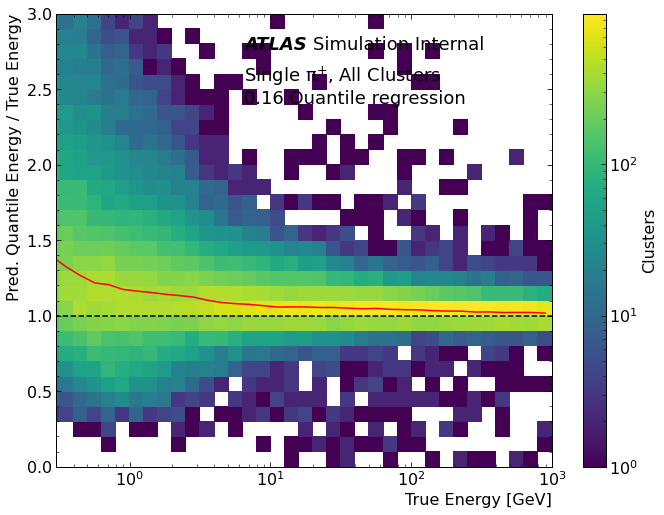

<Figure size 799.992x599.976 with 0 Axes>

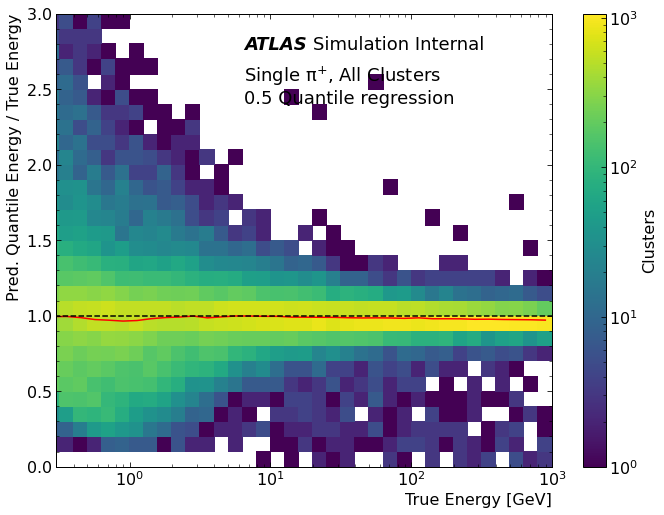

<Figure size 799.992x599.976 with 0 Axes>

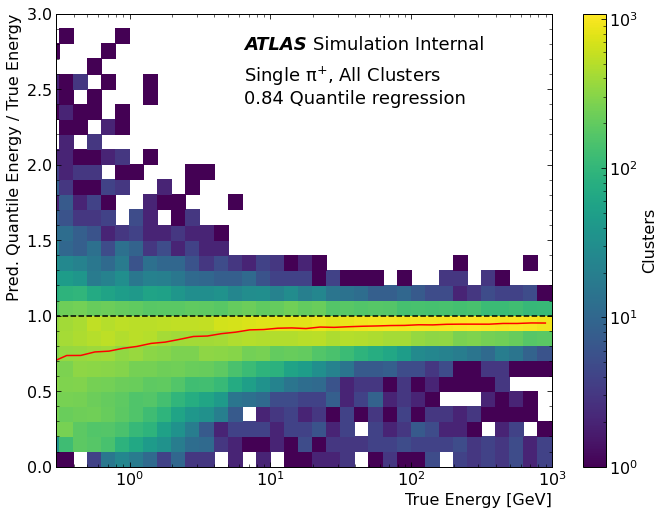

In [21]:
regQuant = []
for q in quantiles:
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test]['quantile_'+str(q)+'_EoverCalib'], 
                      figfile = plotpath+'quantile_'+str(q)+'_response.pdf', statistic = 'median',
                      xlabel = 'True Energy [GeV]', ylabel = 'Pred. Quantile Energy / True Energy',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Quantile regression'}])
    regQuant.append(rq)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

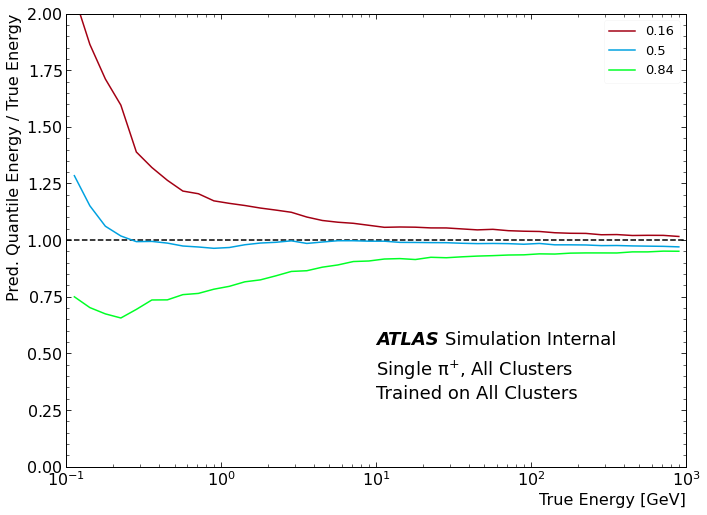

In [22]:
pu.lineOverlay(xcenter=xcenter, lines = regQuant,
                labels = [str(q) for q in quantiles],
                xlabel = 'True Energy [GeV]', ylabel = 'Pred. Quantile Energy / True Energy',
                figfile = plotpath + "quantile_overlay.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

#### DNN IQR Studies

In [23]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

regressor_All = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200, epochs=100, verbose=1)
regressor_All.model = load_model(modelpath + 'dnn_regressor.h5')

pdata['piplus']['predict_regressor_All'] = np.exp(scaler_cal['piplus'].inverse_transform(regressor_All.predict(All_input['piplus'])))
pdata['piplus']['predict_regressor_All_EoverCalib'] = pdata['piplus'].predict_regressor_All / pdata['piplus'].cluster_ENG_CALIB_TOT

2180/2180 [==============================] - 4s 2ms/step


<Figure size 799.992x599.976 with 0 Axes>

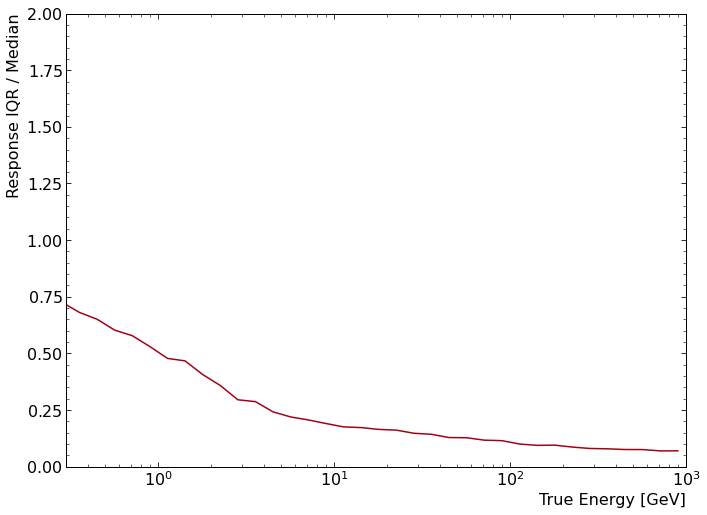

<Figure size 799.992x599.976 with 0 Axes>

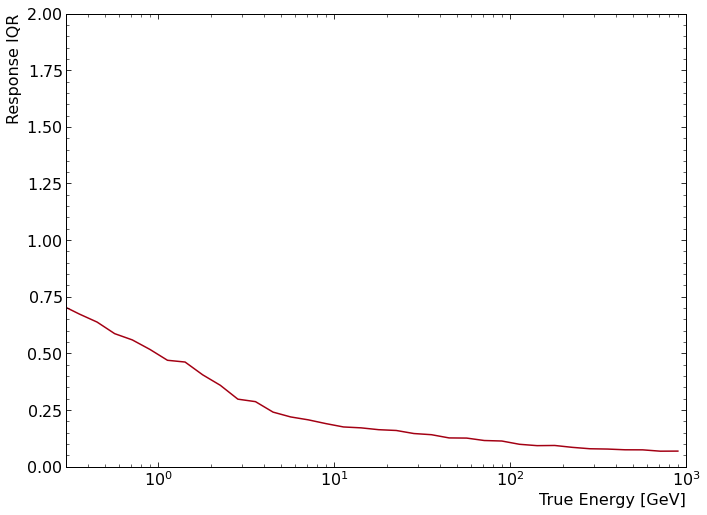

<Figure size 799.992x599.976 with 0 Axes>

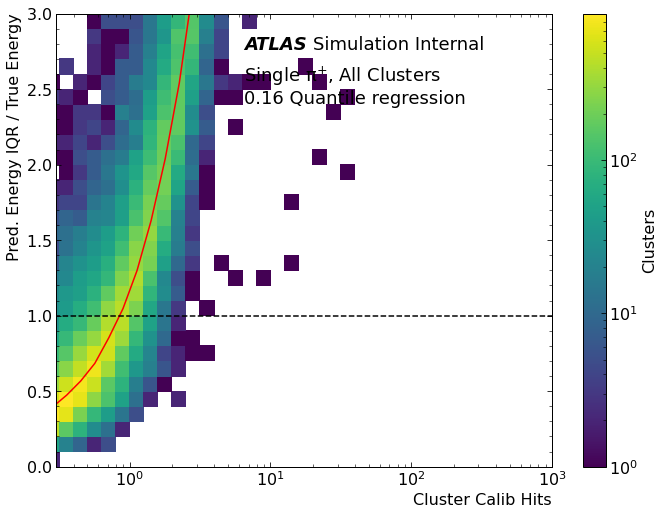

<Figure size 799.992x599.976 with 0 Axes>

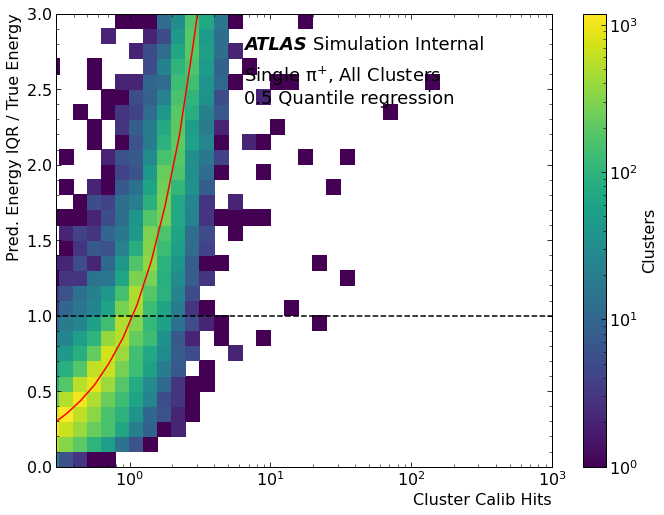

<Figure size 799.992x599.976 with 0 Axes>

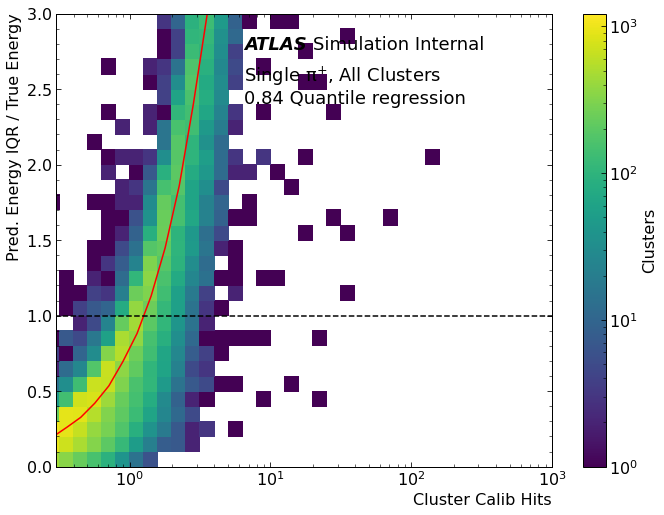

In [24]:
xcenter, iqrOverMed_DNN = ru.resolutionPlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                        pdata['piplus'][pdata['piplus'].test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

xcenter, iqrOverTrue_DNN = resolutionPlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                        pdata['piplus'][pdata['piplus'].test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

# xcenter, med = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
#                         pdata['piplus'][pdata['piplus'].test]['quantile_0.5'], statistic='median',
#                               ylabel='Cluster Energy', figfile = plotpath + 'median_energy.pdf')

# orderedQuant_raw = []
# for sel, q in zip([pdata_upper, pdata_lower], [0.75, 0.25]):
#     xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test & sel].cluster_ENG_CALIB_TOT,
#                       pdata['piplus'][pdata['piplus'].test & sel]['ordered_'+str(q)], 
#                       statistic = 'median',
#                       xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
#                       atlas_x = 0.38, atlas_y = 0.95, simulation = True,
#                       textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
#                                  {'x': 0.38, 'y': 0.8, 'text': str(q)+' Ordered Quantile'}])
#     orderedQuant_raw.append(rq)
    
regQuant_raw = []
for q in quantiles:
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test]['quantile_'+str(q)], 
                      statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Pred. Energy IQR / True Energy',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Quantile regression'}])
    regQuant_raw.append(rq)

<Figure size 799.992x599.976 with 0 Axes>

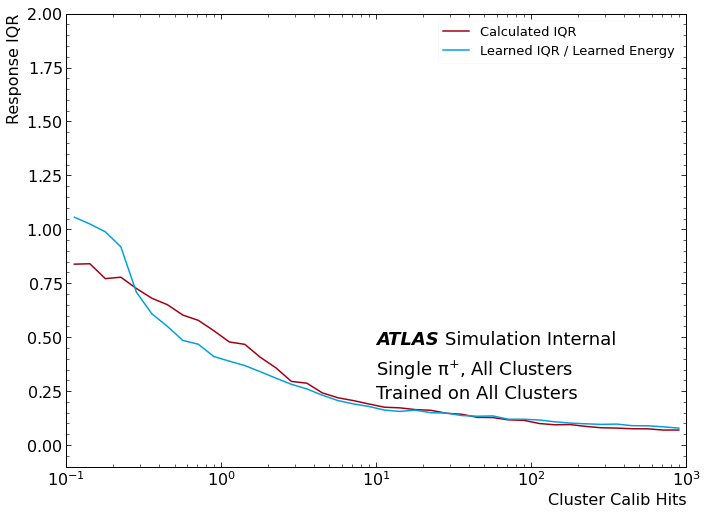

In [25]:
# iqrOverTrue_DNN_learned = (regQuant_raw[0]-regQuant_raw[2])/pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT
iqrOverMed_DNN_learned = (regQuant_raw[0]-regQuant_raw[2])/regQuant_raw[1]

pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMed_DNN, iqrOverMed_DNN_learned],# iqrOverTrue_DNN_learned],
                labels = ['Calculated IQR','Learned IQR / Learned Energy'],
                xlabel = 'Cluster Calib Hits', ylabel = 'Response IQR',
                figfile = plotpath + "iqr_overlay.pdf",
                y_min=-0.1, #extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

## IQR Accuracy Study

In [26]:
# proportion of data within IQR
sel = (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT'])\
    & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])
n_iqr = len(pdata['piplus']['cluster_ENG_CALIB_TOT'][sel & pdata['piplus'].test])
float(n_iqr) / len(pdata['piplus']['cluster_ENG_CALIB_TOT'][pdata['piplus'].test])

0.6591354810592593

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

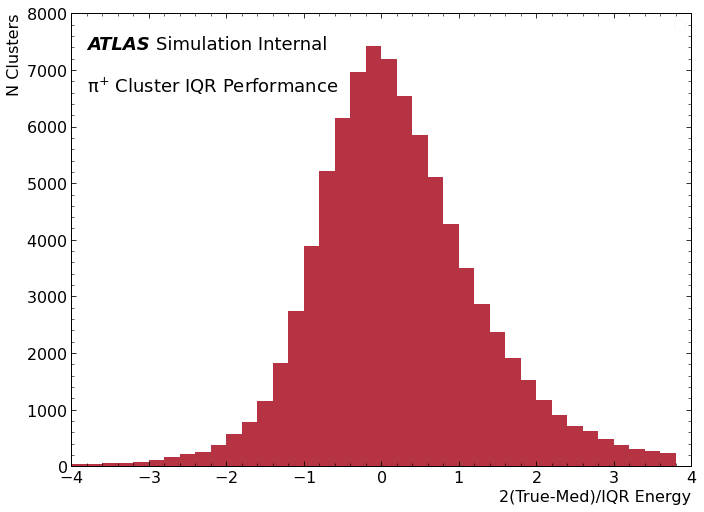

In [27]:
# distribution of differences from predicted mean
x = 2*(pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])/(pdata['piplus']['quantile_0.16']-pdata['piplus']['quantile_0.84'])
# x = (pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])

x_min = -4
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

plt.cla()
plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

sel = pdata['piplus'].test
plt.hist(x[sel], bins = xbin, density = False, alpha = alpha)

# sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT']) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])
# plt.hist(x[sel], bins = xbin, density = False, alpha = alpha, label = 'Within 68\% IQR')
# n1 = len(x[sel])

# sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] > pdata['piplus']['cluster_ENG_CALIB_TOT'])
# plt.hist(x[sel], bins = xbin, density = False, alpha = alpha, label = 'Below 16\%')
# n0 = len(x[sel])

# sel = pdata['piplus'].test & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > pdata['piplus']['quantile_0.16'])
# plt.hist(x[sel], bins = xbin, density = False, alpha = alpha, label = 'Above 84\%')
# n2 = len(x[sel])

# plt.yscale('log')
plt.xlim(x_min, x_max)
ampl.set_xlabel('2(True-Med)/IQR Energy')
ampl.set_ylabel('N Clusters')
ampl.draw_atlas_label(0.025, 0.95, simulation='internal', fontsize=18)
fig.axes[0].text(0.025, 0.825, "$\pi^{+}$ Cluster IQR Performance", transform=fig.axes[0].transAxes, fontsize=18)
# fig.axes[0].text(0.025, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
plt.legend()
plt.savefig(plotpath+'iqr_accuracy.pdf')
plt.show()


No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

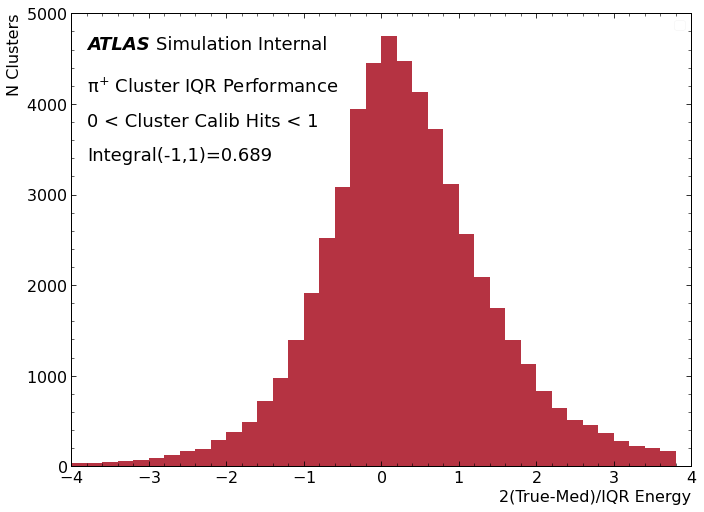

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

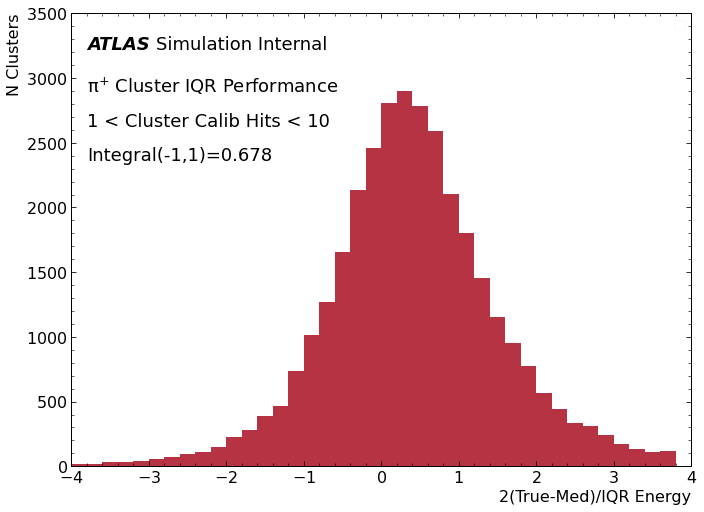

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

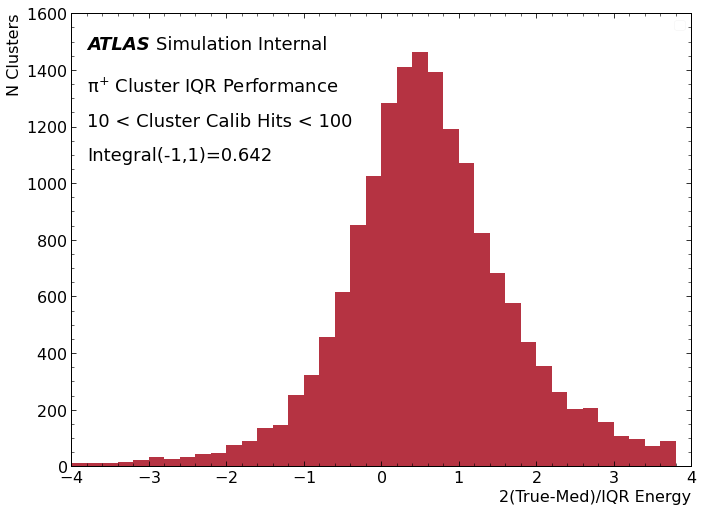

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

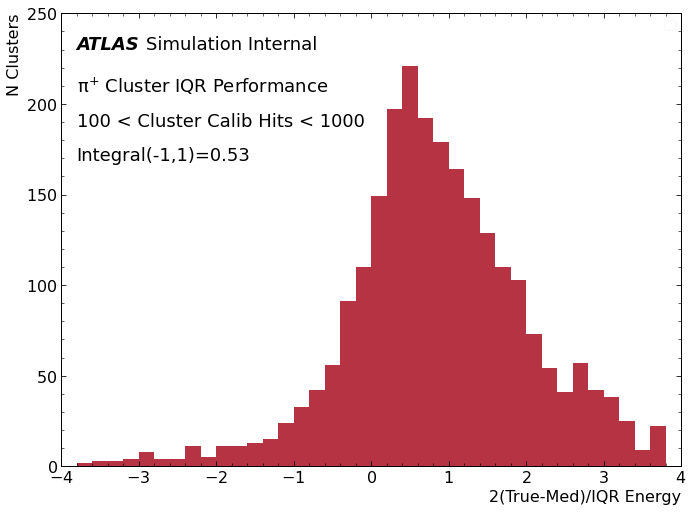

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

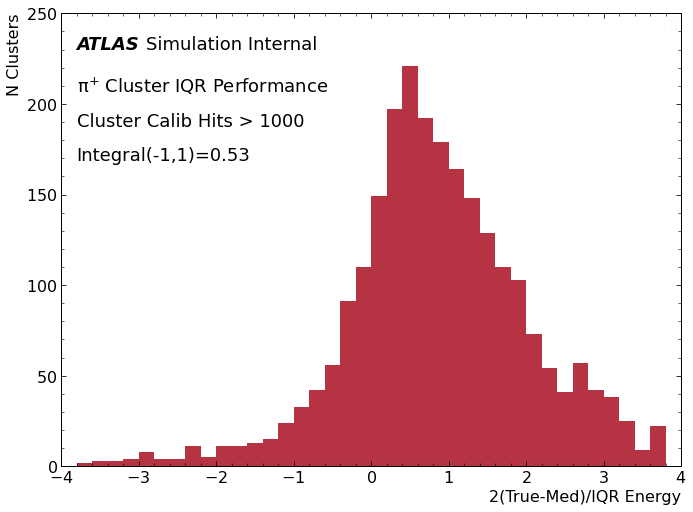

In [28]:
# distribution of differences from predicted mean
# binned in true energy
energy_bins = [0,1,10,100,1000]

x = 2*(pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])/(pdata['piplus']['quantile_0.16']-pdata['piplus']['quantile_0.84'])
# x = (pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])

x_min = -4
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

totals = np.zeros(len(energy_bins))
hists = []
for i in range(len(energy_bins)):
    if( i == len(energy_bins)-1 ):
        label = 'Cluster Calib Hits > '+str(energy_bins[i])
        sel_energy = pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]
    else:
        label = str(energy_bins[i])+' < Cluster Calib Hits < '+str(energy_bins[i+1])
        sel_energy = (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i+1])

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    sel = pdata['piplus'].test
    hists.append(
        plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha)
    )
    total = len(x[sel & sel_energy])
    inte = 0
    for j in range(15,25+1):
        inte += hists[i][0][j]
    ratio = str(round(float(inte)/total,3))

    # plt.yscale('log')
    plt.xlim(x_min, x_max)
    ampl.set_xlabel('2(True-Med)/IQR Energy')
    ampl.set_ylabel('N Clusters')
    ampl.draw_atlas_label(0.025, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.025, 0.825, "$\pi^{+}$ Cluster IQR Performance", transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.025, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.025, 0.675, 'Integral(-1,1)='+ratio, transform=fig.axes[0].transAxes, fontsize=18)
    plt.legend()
    plt.savefig(plotpath+'iqr_accuracy_binned_'+str(i)+'.pdf')
    plt.show()


<Figure size 799.992x599.976 with 0 Axes>

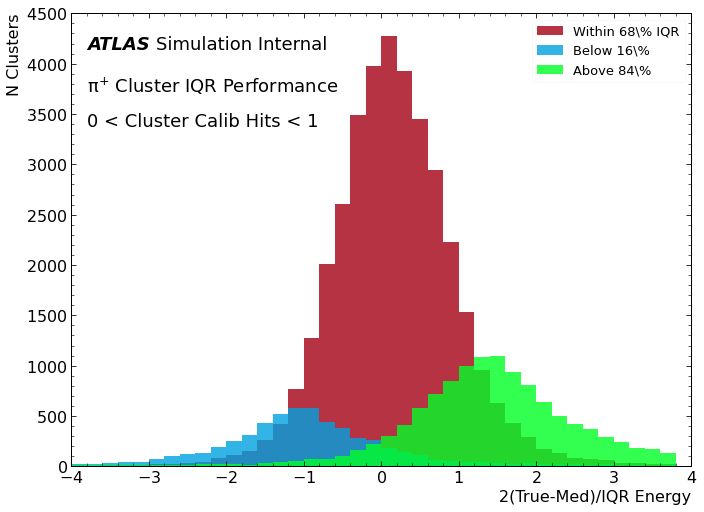

<Figure size 799.992x599.976 with 0 Axes>

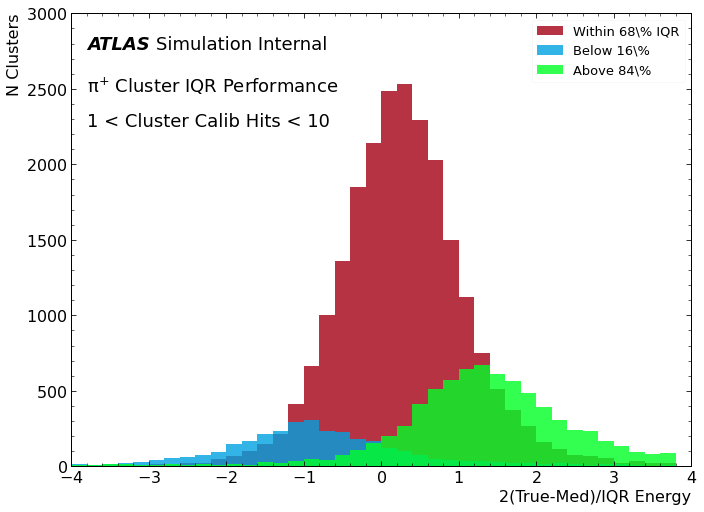

<Figure size 799.992x599.976 with 0 Axes>

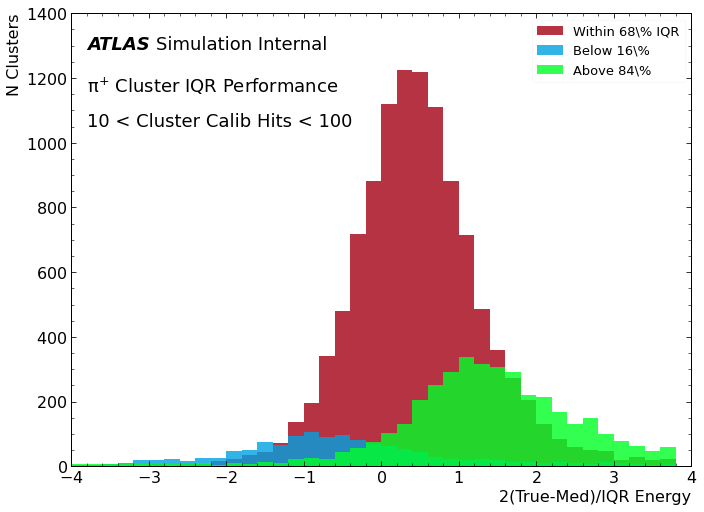

<Figure size 799.992x599.976 with 0 Axes>

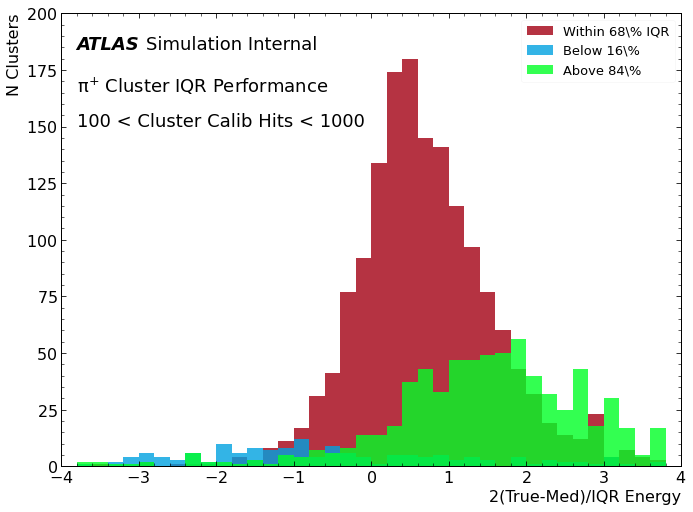

<Figure size 799.992x599.976 with 0 Axes>

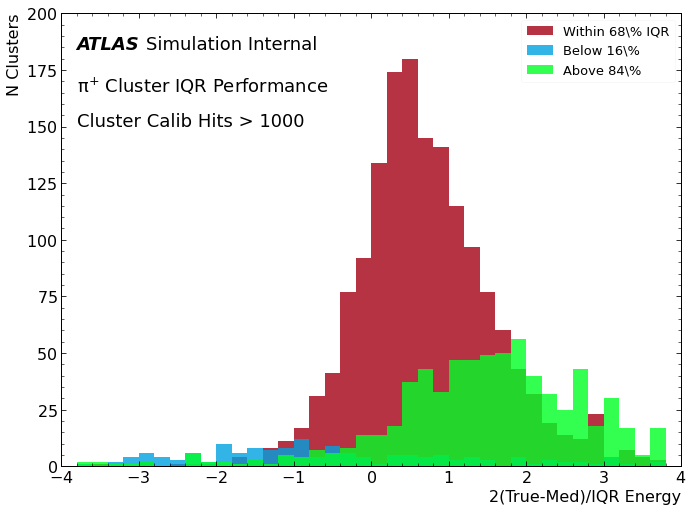

In [29]:
# partitioned distributions of differences from predicted mean
# binned in true energy
energy_bins = [0,1,10,100,1000]

x = 2*(pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])/(pdata['piplus']['quantile_0.16']-pdata['piplus']['quantile_0.84'])
# x = (pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])

x_min = -4
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

totals = np.zeros(len(energy_bins))
hists = []
for i in range(len(energy_bins)):
    if( i == len(energy_bins)-1 ):
        label = 'Cluster Calib Hits > '+str(energy_bins[i])
        sel_energy = pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]
    else:
        label = str(energy_bins[i])+' < Cluster Calib Hits < '+str(energy_bins[i+1])
        sel_energy = (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i+1])

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT']) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Within 68\% IQR')
    n1 = len(x[sel & sel_energy])

    sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] > pdata['piplus']['cluster_ENG_CALIB_TOT'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Below 16\%')
    n0 = len(x[sel & sel_energy])

    sel = pdata['piplus'].test & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > pdata['piplus']['quantile_0.16'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Above 84\%')
    n2 = len(x[sel & sel_energy])

    # plt.yscale('log')
    plt.xlim(x_min, x_max)
    ampl.set_xlabel('2(True-Med)/IQR Energy')
    ampl.set_ylabel('N Clusters')
    ampl.draw_atlas_label(0.025, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.025, 0.825, "$\pi^{+}$ Cluster IQR Performance", transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.025, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
    plt.legend()
    plt.savefig(plotpath+'iqr_accuracy_partitioned_binned_'+str(i)+'.pdf')
    plt.show()

<Figure size 799.992x599.976 with 0 Axes>

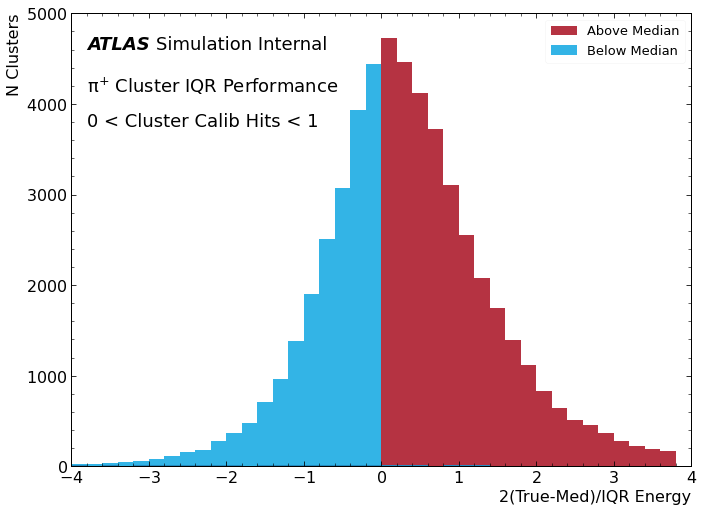

<Figure size 799.992x599.976 with 0 Axes>

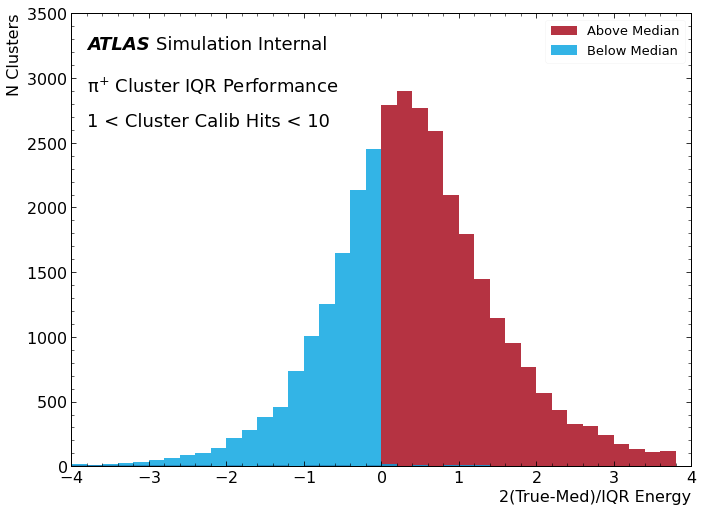

<Figure size 799.992x599.976 with 0 Axes>

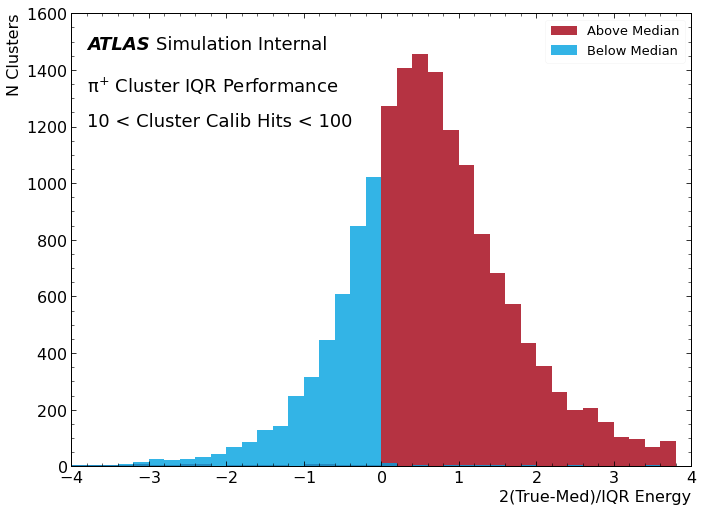

<Figure size 799.992x599.976 with 0 Axes>

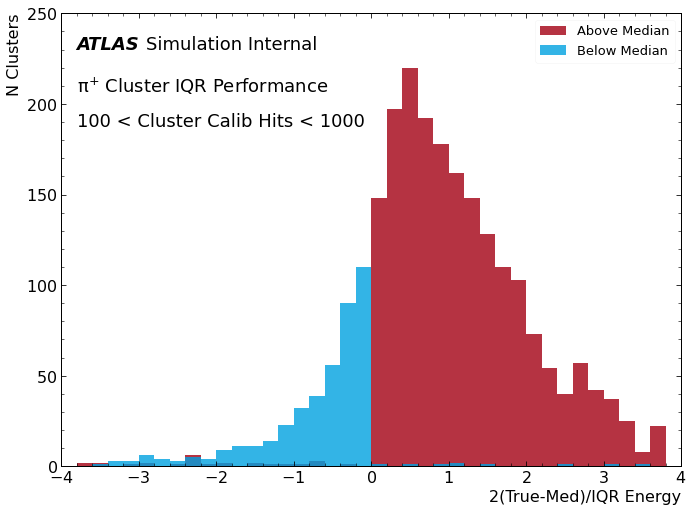

<Figure size 799.992x599.976 with 0 Axes>

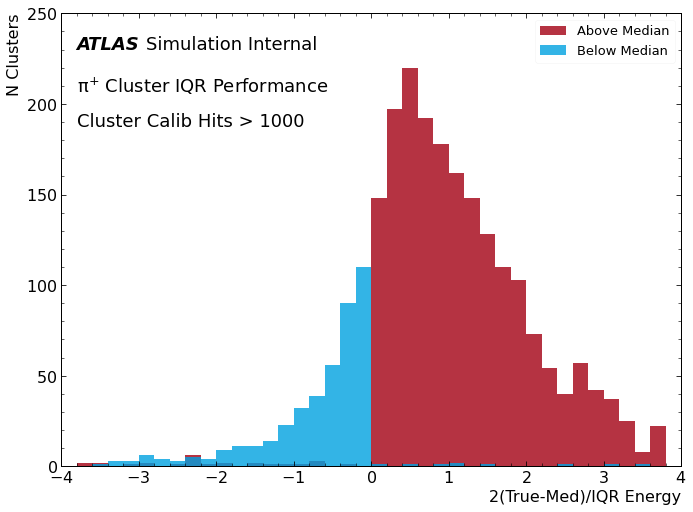

In [30]:
# median split of differences from predicted mean
# binned in true energy
energy_bins = [0,1,10,100,1000]

x = 2*(pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])/(pdata['piplus']['quantile_0.16']-pdata['piplus']['quantile_0.84'])
# x = (pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])

x_min = -4
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

totals = np.zeros(len(energy_bins))
hists = []
for i in range(len(energy_bins)):
    if( i == len(energy_bins)-1 ):
        label = 'Cluster Calib Hits > '+str(energy_bins[i])
        sel_energy = pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]
    else:
        label = str(energy_bins[i])+' < Cluster Calib Hits < '+str(energy_bins[i+1])
        sel_energy = (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i+1])

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.5'] < pdata['piplus']['cluster_ENG_CALIB_TOT'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Above Median')
    n1 = len(x[sel & sel_energy])

    sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.5'] > pdata['piplus']['cluster_ENG_CALIB_TOT'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Below Median')
    n0 = len(x[sel & sel_energy])

    # plt.yscale('log')
    plt.xlim(x_min, x_max)
    ampl.set_xlabel('2(True-Med)/IQR Energy')
    ampl.set_ylabel('N Clusters')
    ampl.draw_atlas_label(0.025, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.025, 0.825, "$\pi^{+}$ Cluster IQR Performance", transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.025, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
    plt.legend()
    plt.savefig(plotpath+'iqr_accuracy_median_binned_'+str(i)+'.pdf')
    plt.show()

# MDN Quantile Prediction

In [31]:
def MDN():
    event_shape = [1]
    num_components = 1
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=params_size, activation=None))
        model.add(tfp.layers.MixtureNormal(num_components, event_shape,
                                    convert_to_tensor_fn=lambda X: tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)))
        opt = Adam(learning_rate=1e-6)#, decay=1e-6)
        model.compile(optimizer=opt, loss=lambda y, model: -model.log_prob(y))
    return model

regressor_All = MDN()
regressor_All.load_weights(modelpath + 'mdn_regressor.h5')

pred = regressor_All.predict(All_input['piplus'])
pdata['piplus']['predict_regressor_MDN'] = np.exp(scaler_cal['piplus'].inverse_transform(pred[:,0]))
pdata['piplus']['predict_regressor_MDN_EoverCalib'] = pdata['piplus'].predict_regressor_MDN / pdata['piplus'].cluster_ENG_CALIB_TOT

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [32]:
median = pred[:,0]
sigma = pred[:,1]

_median = scaler_cal['piplus'].scale_ * median
_sigma = scaler_cal['piplus'].scale_ * sigma #_median * (sigma / median)

_median = _median + scaler_cal['piplus'].mean_

_median = np.exp(_median)   # Reconstructed Energy Per Cluster
_sigma = _median * _sigma   # Reconstructed Energy Uncertainty (Std dev) Per Cluster

median_over_true = _median / pdata['piplus'].cluster_ENG_CALIB_TOT   #   Reconstructed Energy / True Energy
iqr_over_median = 2 * _sigma / _median  # Reconstructed Energy Resolution Per Cluster
iqr_over_true = 2 * _sigma / pdata['piplus'].cluster_ENG_CALIB_TOT  # Reconstructed Energy Resolution Per Cluster


pdata['piplus']['quantile_0.16'] = _median - _sigma
pdata['piplus']['quantile_0.5'] = _median
pdata['piplus']['quantile_0.84'] = _median + _sigma

for q in quantiles:
    pdata['piplus']['quantile_'+str(q)+'_EoverCalib'] = pdata['piplus']['quantile_'+str(q)] / pdata['piplus'].cluster_ENG_CALIB_TOT

#### MDN Quantile Visualization

<Figure size 799.992x599.976 with 0 Axes>

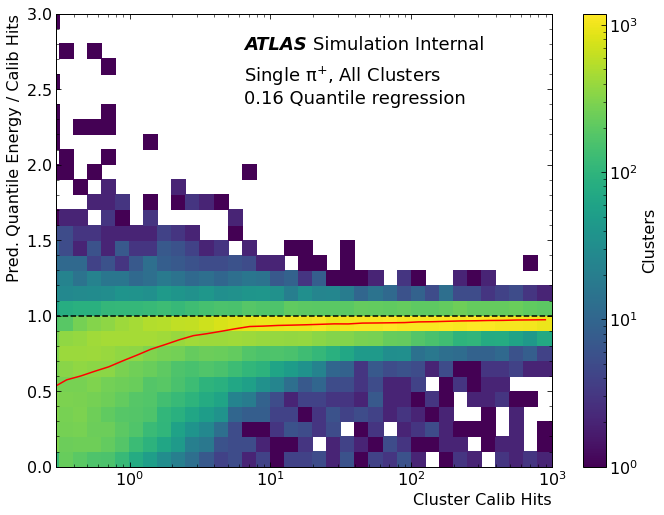

<Figure size 799.992x599.976 with 0 Axes>

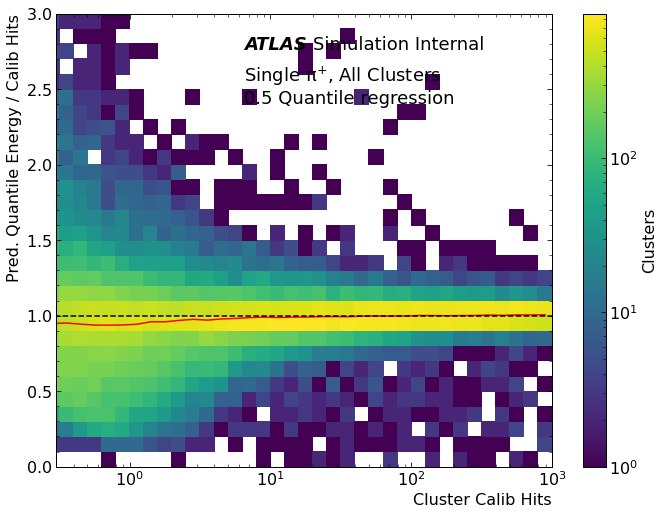

<Figure size 799.992x599.976 with 0 Axes>

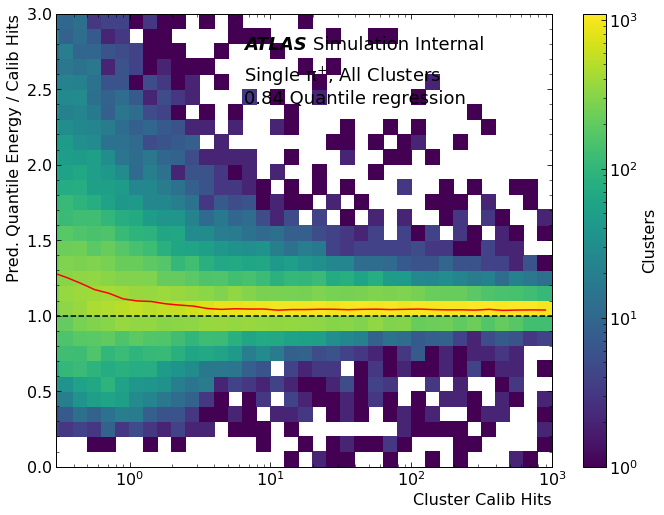

In [33]:
regQuant = []
for q in quantiles:
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test]['quantile_'+str(q)+'_EoverCalib'], 
                      figfile = plotpath+'quantile_'+str(q)+'_response.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Pred. Quantile Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Quantile regression'}])
    regQuant.append(rq)

<Figure size 799.992x599.976 with 0 Axes>

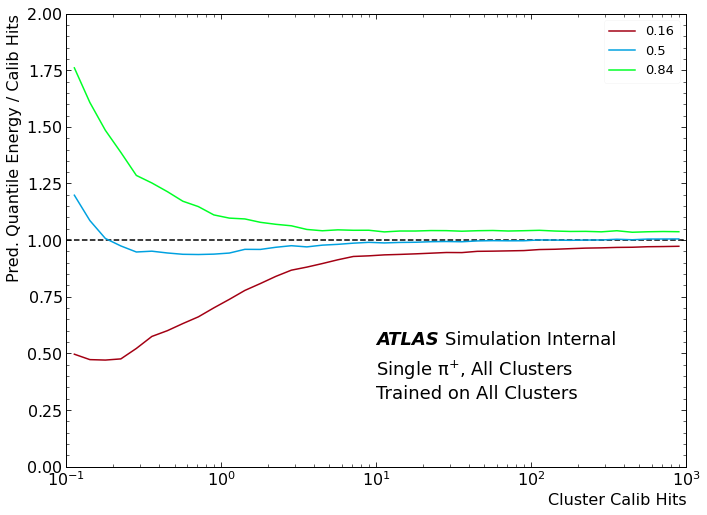

In [34]:
pu.lineOverlay(xcenter=xcenter, lines = regQuant,
                labels = [str(q) for q in quantiles],
                xlabel = 'Cluster Calib Hits', ylabel = 'Pred. Quantile Energy / Calib Hits',
                figfile = plotpath + "quantile_overlay.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

#### MDN IQR Studies

Whole dataset true IQR

<Figure size 799.992x599.976 with 0 Axes>

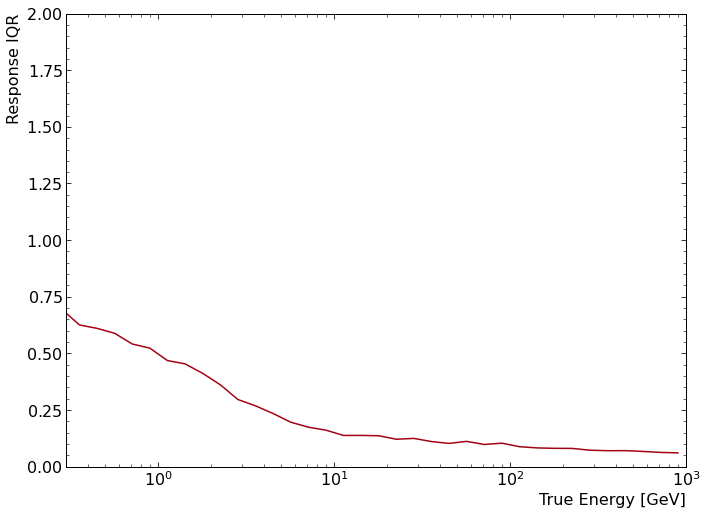

In [35]:
xcenter, iqrOverTrue_MDN = resolutionPlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                        pdata['piplus'][pdata['piplus'].test].predict_regressor_MDN_EoverCalib)

Learned IQR

<Figure size 799.992x599.976 with 0 Axes>

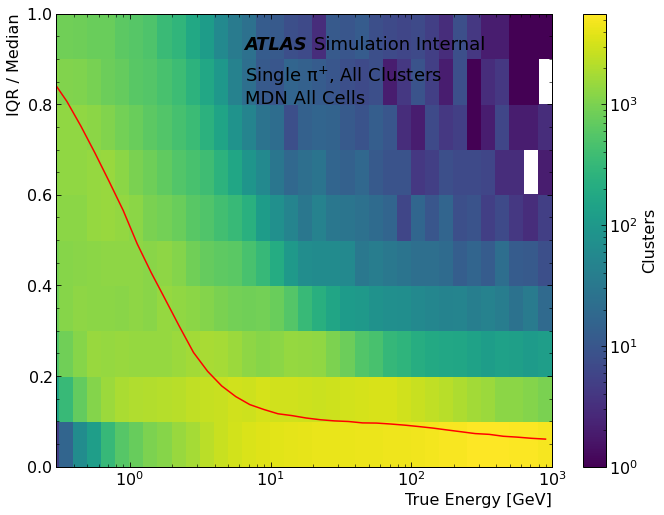

<Figure size 799.992x599.976 with 0 Axes>

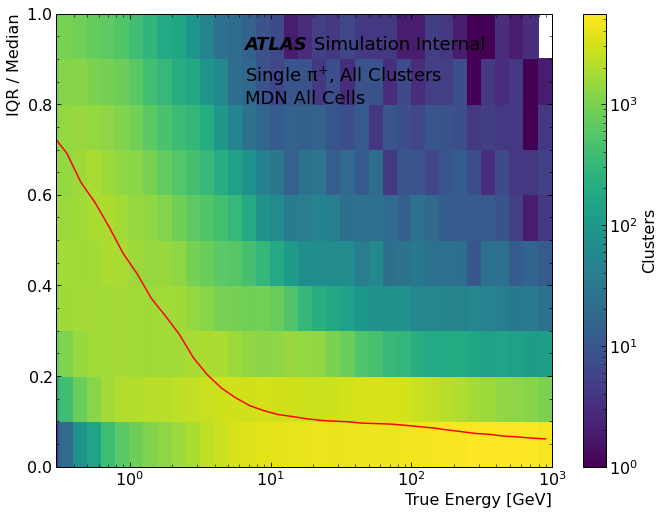

In [36]:
xcenter, iqrOverMed_MDN_learned = ru.responsePlot(pdata['piplus'].cluster_ENG_CALIB_TOT, iqr_over_median,
                 plotpath+'hist_2D_calib_vs_sigma.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,1), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='IQR / Median',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN All Cells'}])

xcenter, iqrOverTrue_MDN_learned = ru.responsePlot(pdata['piplus'].cluster_ENG_CALIB_TOT, iqr_over_true,
                 plotpath+'hist_2D_calib_vs_sigma.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,1), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='IQR / Median',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN All Cells'}])

# Learned IQR Comparison of DNN vs. MDN

<Figure size 799.992x599.976 with 0 Axes>

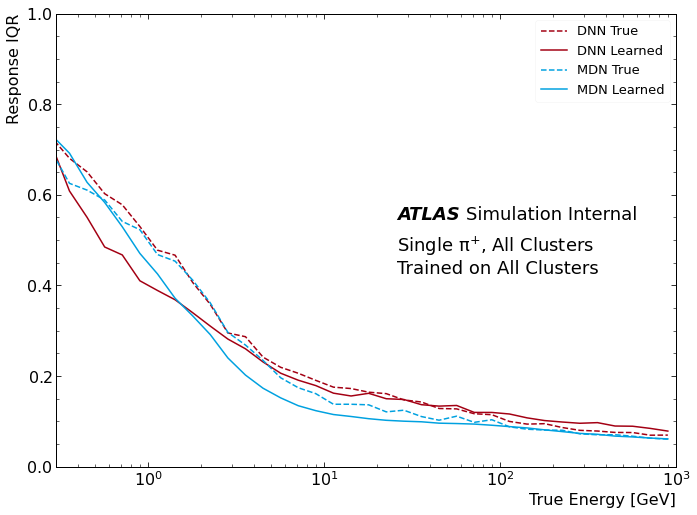

In [37]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMed_DNN, iqrOverMed_DNN_learned, iqrOverTrue_MDN, iqrOverTrue_MDN_learned],#, iqrOverMed_MDN_learned],
                labels = ['DNN True', 'DNN Learned', 'MDN True', 'MDN Learned'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = 1,
                linestyles = ['dashed', 'solid', 'dashed', 'solid'], colorgrouping = 2, # 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                atlas_x = 0.55, atlas_y = 0.575, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.475, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.55, 'y': 0.425, 'text': 'Trained on All Clusters'}])

<Figure size 799.992x599.976 with 0 Axes>

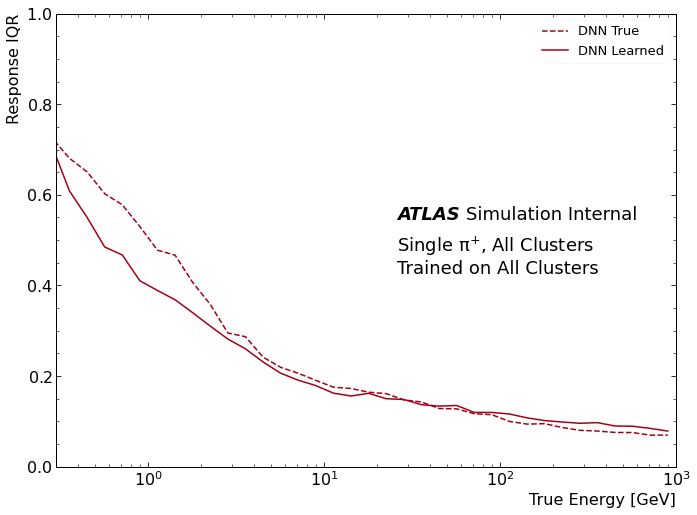

<Figure size 799.992x599.976 with 0 Axes>

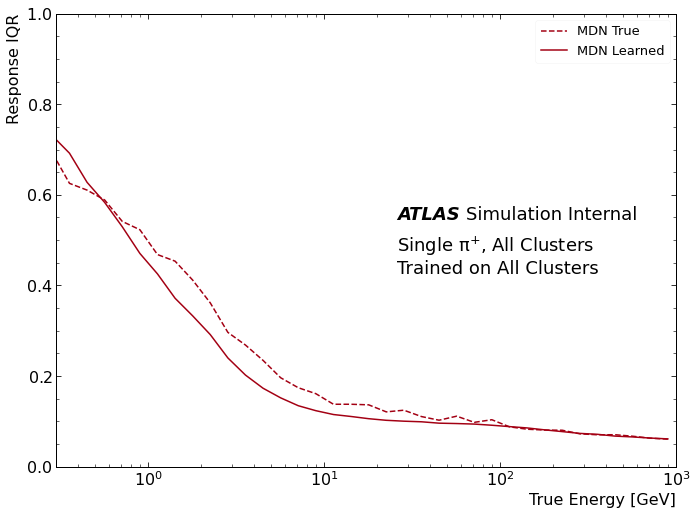

In [38]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMed_DNN, iqrOverMed_DNN_learned],#, iqrOverMed_MDN_learned],
                labels = ['DNN True', 'DNN Learned'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = 1,
                linestyles = ['dashed', 'solid'], colorgrouping = 2, # 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                atlas_x = 0.55, atlas_y = 0.575, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.475, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.55, 'y': 0.425, 'text': 'Trained on All Clusters'}])

pu.lineOverlay(xcenter=xcenter, lines = [iqrOverTrue_MDN, iqrOverTrue_MDN_learned],#, iqrOverMed_MDN_learned],
                labels = ['MDN True', 'MDN Learned'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = 1,
                linestyles = ['dashed', 'solid', 'dashed', 'solid'], colorgrouping = 2, # 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                atlas_x = 0.55, atlas_y = 0.575, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.475, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.55, 'y': 0.425, 'text': 'Trained on All Clusters'}])